In [448]:
import numpy as np
from scipy import constants as c
from scipy import special as sp
from iminuit import Minuit, cost
from argparse import Namespace
import pandas as pd
import os
import matplotlib.pyplot as plt
import h5py as h5
from scipy.signal import find_peaks

In [449]:
KB = c.Boltzmann
hbar = c.Planck

In [452]:
def QT(T,d0, q0, alpha, omega):
    csi = (hbar * omega)/(2*KB*T)
    num = np.exp(-d0/(KB*T))*np.sinh(csi)*sp.kn(0,csi)
    den = np.pi*(1-2*np.exp(-d0/(KB*T))*np.exp(-csi)*sp.iv(0,-csi))
    return num/den * (alpha/2) + 1/q0

def kondo(T,d0, q0, alpha, omega, b, T_k):
    csi = (hbar * omega)/(2*KB*T)
    num = np.exp(-d0/(KB*T))*np.sinh(csi)*sp.kn(0,csi)
    den = np.pi*(1-2*np.exp(-d0/(KB*T))*np.exp(-csi)*sp.iv(0,-csi))
    return num/den * (alpha/2) + 1/q0 - b*np.log(T/T_k)

def retta(x, m, q):
    return m*x + q

def resonance(x, x0, Q, Q_c, phi0):
    num = np.exp(1j*phi0)
    den = 1 + 2*1j*Q*(x-x0)/x0
    return abs(1 - (Q/Q_c)*(num/den))

def model(x,m,q,x0,Q,Q_c,phi0):
    return retta(x,m,q) * resonance(x,x0,Q,Q_c,phi0)

def FWHM(x,y):
    x = np.array(x)
    y = np.array(y)
    half = np.max(y) - (np.max(y)-np.abs(y)) / 2.
    minimums = x[np.where(y < half)]
    if len(minimums)==0: 
        print('Minimum not found!')
        return 0,1
    else:
        return (max(minimums) - min(minimums)),0

def mod(x,y):
    return np.sqrt(x**2 + y**2)
    
def Q_stima(x0,w):
    if (((x0 is None) or (w is None)) or w==0):
        print('Q_stima: None detected!')
        return 0
    else:
        return x0/(2*w)
    
def Sort_Tuple(tup):
 
    # getting length of list of tuples
    lst = len(tup)
    for i in range(0, lst):
        for j in range(0, lst-i-1):
            if (tup[j][1] > tup[j + 1][1]):
                temp = tup[j]
                tup[j] = tup[j + 1]
                tup[j + 1] = temp
    return tup


def plot_res(m2, dfs2, t, func, fill):

    for m in range(len(dfs2)):

        chi2 = m2[m].fval
        ndof = m2[m].ndof

        title = [
            f"chi2/ndof = {chi2:.1f}/{ndof}={chi2/ndof:.1f}",
        ]

        for par in m2[m].parameters:
            title.append(
                f"{par} = {m2[m].values[par]:.4f} +/- {m2[m].errors[par]:.4f}"
            )
        
        for n in range(4):
        
            plt.scatter(np.array(dfs2[m][n]['f'])*1e-9, np.array(dfs2[m][n]['S21']), marker='.', s=1, label='Raw Data', color='black')
            plt.plot(np.array(dfs2[m][n]['f'])*1e-9, func(np.array(dfs2[m][n]['f']), *m2[m].values[:]), label='Model', color='red')
            if fill == True:
                plt.fill_between(np.array(dfs2[m][n]['f'])*1e-9, np.array(dfs2[m][n]['S21'])*(1-(1e-3)), np.array(dfs2[m][n]['S21'])*(1+1e-3), alpha=0.5, color='blue')
            plt.xlabel(r'$\nu$ [GHz]')
            plt.ylabel(r'$|S_{21}|$')
            plt.legend(title="\n".join(title), fontsize='large')
            plt.title('T: '+str(t[m])+' Res: '+str(n))
            plt.grid()
            plt.show()
        return 


def plot_res_matrix(m, dfs, t, func, rows, columns, fill):

    fig, ax = plt.subplots(rows, columns, figsize=(60,20))

    for row in range(rows):
        for col in range(columns):
            i = row*columns + col
            chi2 = m[i].fval
            ndof = m[i].ndof

            title = [
                f"chi2/ndof = {chi2:.1f}/{ndof}={chi2/ndof:.1f}",
            ]

            for par in m[i].parameters:
                title.append(
                    f"{par} = {m[i].values[par]:.4f} +/- {m[i].errors[par]:.4f}"
                )
            
            ax[row][col].scatter(np.array(dfs[row][col]['f'])*1e-9, np.array(dfs[row][col]['S21']), marker='.', s=1, label='Raw Data', color='black')
            ax[row][col].plot(np.array(dfs[row][col]['f'])*1e-9, func(np.array(dfs[row][col]['f']), *m[i].values[:]), label='Model', color='red')
            if (fill==True):
                ax[row][col].fill_between(np.array(dfs[row][col]['f'])*1e-9, np.array(dfs[row][col]['S21'])*(1-(1e-3)), np.array(dfs[row][col]['S21'])*(1+1e-3), alpha=0.5, color='blue')
            ax[row][col].set_facecolor('bisque')
            ax[row][col].set_xlabel(r'$\nu$ [GHz]')
            ax[row][col].set_ylabel(r'$|S_{21}|$')
            ax[row][col].legend(title="\n".join(title), fontsize='large')
            ax[row][col].set_title('T: '+str(t[i]))
            ax[row][col].grid()
            fig.tight_layout()

    return fig

def read_files(dir = 'C:\\Users\\kid\\SynologyDrive\\Lab2023\\KIDs\\QTLab2324\\IRdetection\\Instruments\\Test_data\\data_19_02_set2\\'):

    dfs, dictionaries = [], []

    for folder in os.listdir(dir):
        if ('T' in folder):
            parent = dir+folder+'\\'
            dictionaries = []
            for (i,filename) in enumerate(os.listdir(parent)):
                my_dest = filename.replace('.h5','.hdf5')
                my_source = parent + filename
                my_dest = parent + my_dest
                os.rename(my_source, my_dest)
                with h5.File(my_dest, 'r') as r:
                    group = r.require_group(name='raw_data')
                    dic = dict()
                    for c in group.items():
                        dic[c[0]] = c[1][:]
                dictionaries.append(dic)
        dfs.append(dictionaries)
    return dfs

In [453]:
dfs = read_files()

I dictionaries sono siffatti: \
    dfs[i][j]['chiave']\
        i = [0,12] --> Temperatures\
        j = [0,3]  --> Resonance(T)\
        chiave = ['i', 'q', 'f']

In [458]:
temps = np.arange(50, 290, 20)

In [459]:
migrads = []
for i in range(12):
    for j in range(4):
        dfs[i][j]['S21'] = 20*np.log10(np.sqrt(np.array(dfs[i][j]['i'])**2 + np.array(dfs[i][j]['q'])**2))
        width,_ = FWHM(np.array(dfs[i][j]['f']),(np.array(dfs[i][j]['S21'])))
        stima_x0 = float(np.array(dfs[i][j]['f'])[np.where(np.array(dfs[i][j]['S21']) == np.min(np.array(dfs[i][j]['S21'])))[0]])
        stima_Q = float(Q_stima(stima_x0,width))
        stima_m = float(((np.array(dfs[i][j]['S21']))[0]-(np.array(dfs[i][j]['S21']))[-1])/(np.array(dfs[i][j]['f'])[0]-np.array(dfs[i][j]['f'])[-1]))
        stima_q = (np.array(dfs[i][j]['S21']))[0] - stima_m * (np.array(dfs[i][j]['f']))[0]
        stima_Q_c = 10600
        stima_phi = 0.2
        lsq = cost.LeastSquares(np.array(dfs[i][j]['f']), np.array(dfs[i][j]['S21']), np.array(dfs[i][j]['S21'])*0.001, model)
        minuit = Minuit(lsq, m=0, q=stima_q, x0=stima_x0, Q=stima_Q, Q_c = stima_Q_c, phi0=stima_phi)
        migrads.append(minuit)

In [460]:
m2, temps2, dfs2 = [], [], []
for i in range(13):
#migrads[i].fixed['m']=True
#migrads[i].fixed['Q_c']=True
#migrads[i].fixed['q']=True
#migrads[i].limits = [(None, None), (None, None), (None, None), (4e3, None), (9e3, 11e3), (0,1)]
    migrads[i].migrad(ncall=10000)
    if (migrads[i].valid==True):
        dfs2.append(dfs[i])
        temps2.append(temps[i]*1e-3)
        m2.append(migrads[i])
    else:
        print(temps[i])

130
150
170


C:\Users\kid\AppData\Local\Temp\ipykernel_5448\3310082717.py:18: RuntimeWarning: invalid value encountered in true_divide
  den = 1 + 2*1j*Q*(x-x0)/x0
C:\Users\kid\AppData\Local\Temp\ipykernel_5448\3310082717.py:19: RuntimeWarning: invalid value encountered in true_divide
  return abs(1 - (Q/Q_c)*(num/den))


250


IndexError: index 12 is out of bounds for axis 0 with size 12

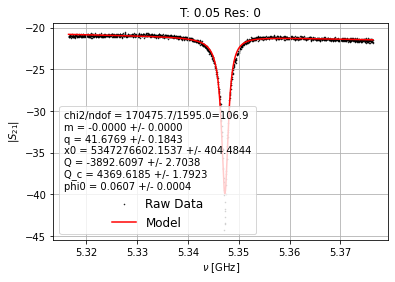

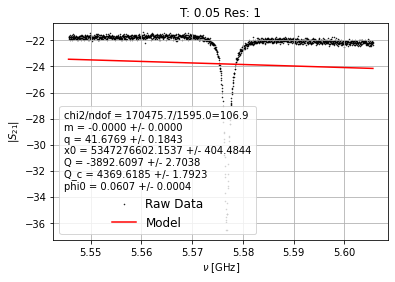

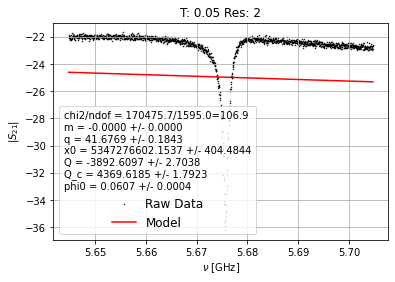

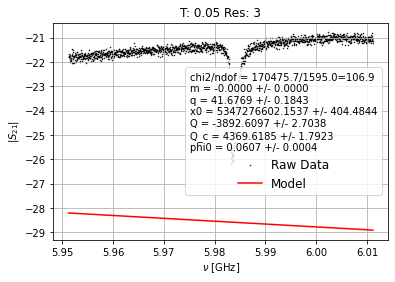

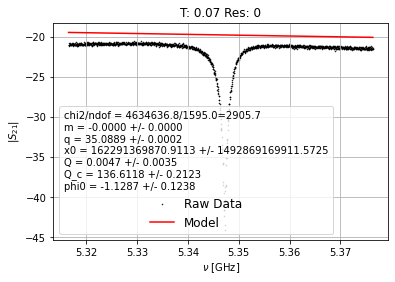

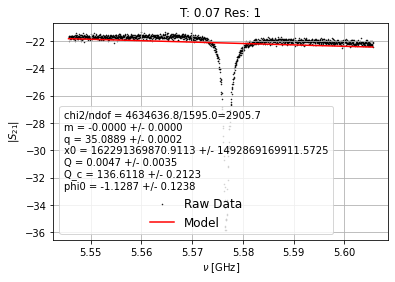

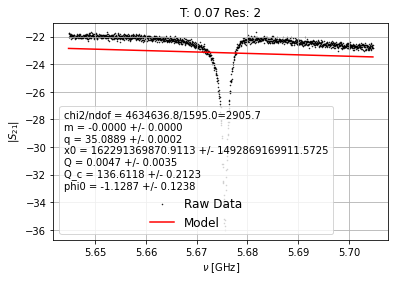

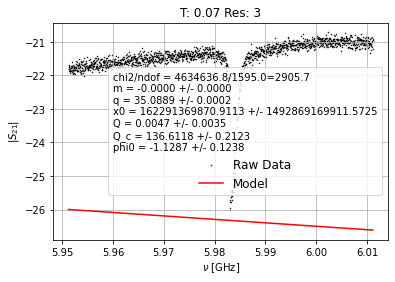

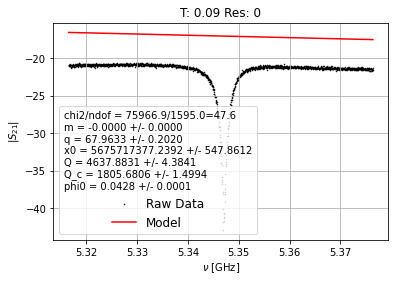

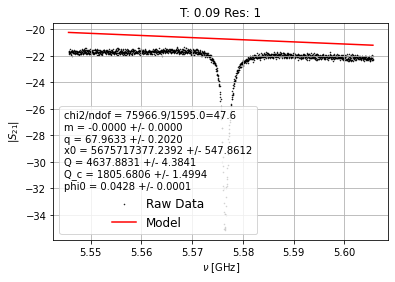

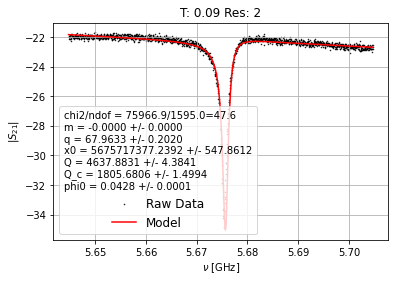

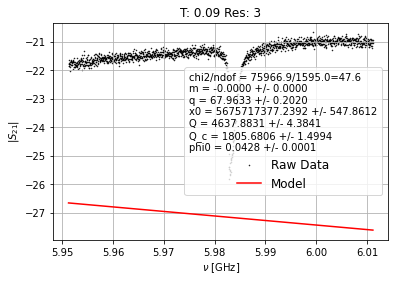

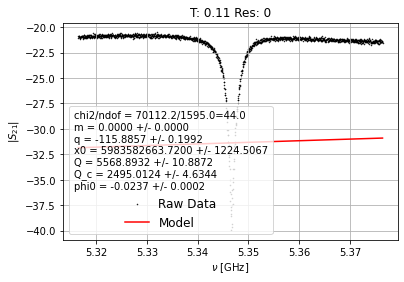

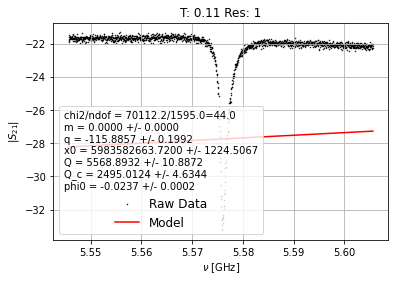

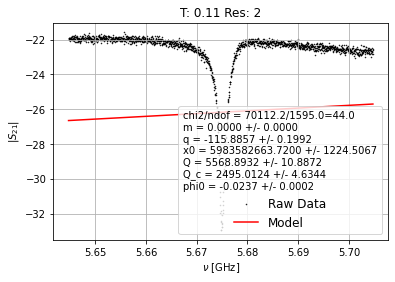

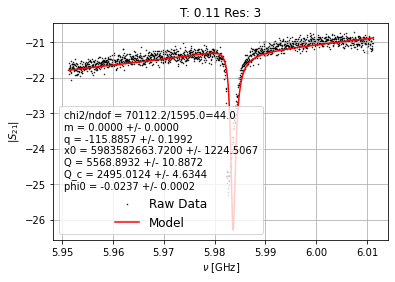

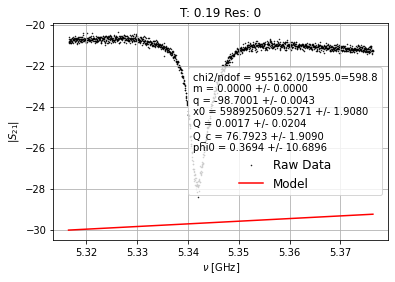

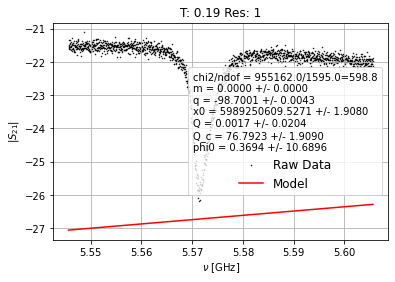

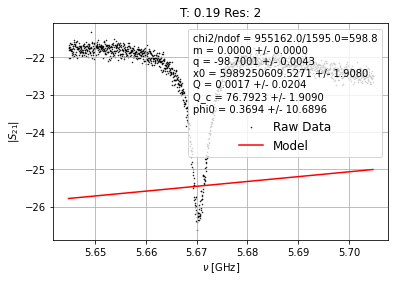

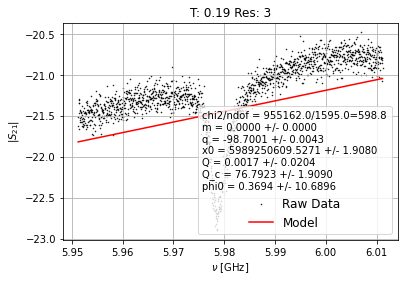

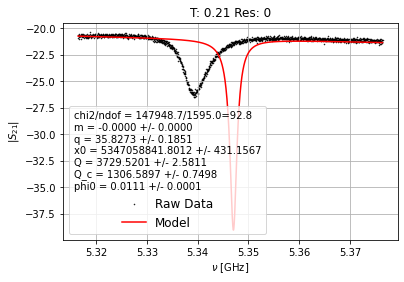

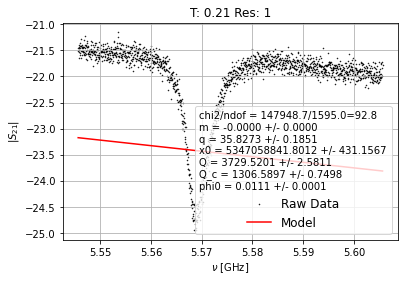

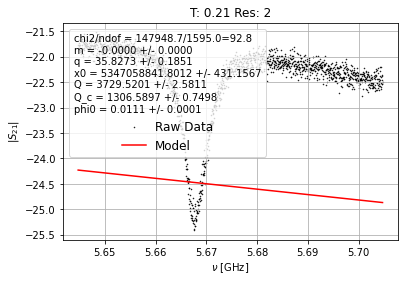

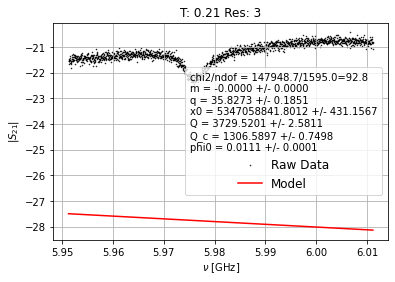

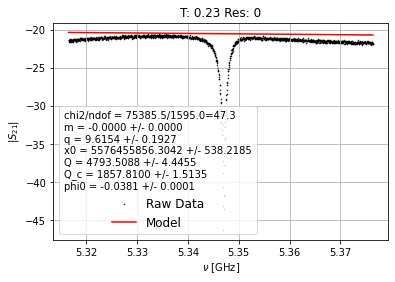

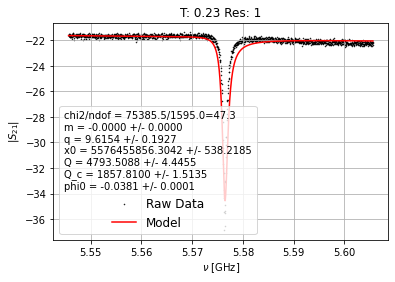

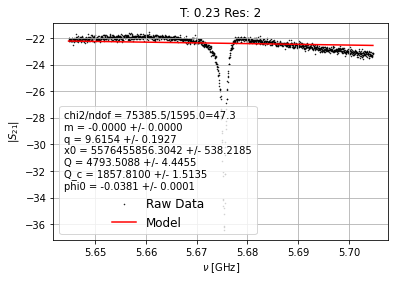

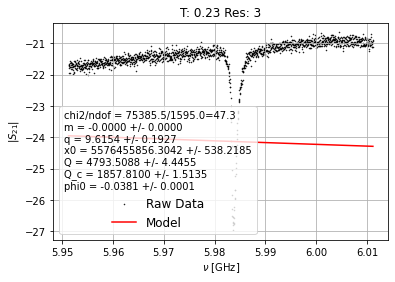

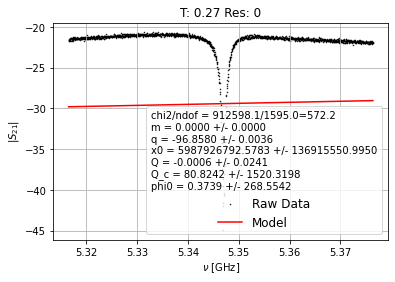

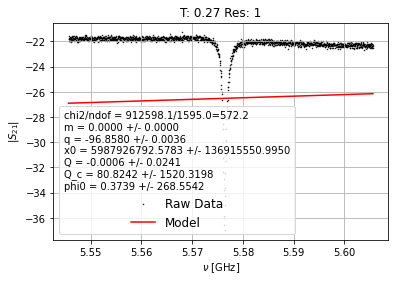

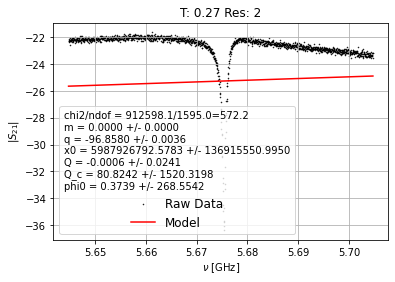

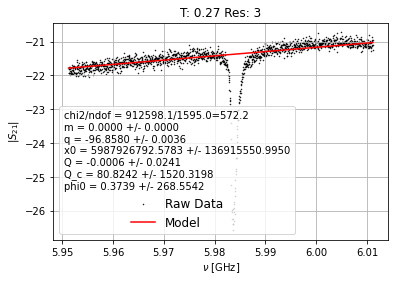

In [461]:
for m in range(len(dfs2)):

    chi2 = m2[m].fval
    ndof = m2[m].ndof

    title = [
        f"chi2/ndof = {chi2:.1f}/{ndof}={chi2/ndof:.1f}",
    ]

    for par in m2[m].parameters:
        title.append(
            f"{par} = {m2[m].values[par]:.4f} +/- {m2[m].errors[par]:.4f}"
        )
    
    for n in range(4):
    
        plt.scatter(np.array(dfs2[m][n]['f'])*1e-9, np.array(dfs2[m][n]['S21']), marker='.', s=1, label='Raw Data', color='black')
        plt.plot(np.array(dfs2[m][n]['f'])*1e-9, model(np.array(dfs2[m][n]['f']), *m2[m].values[:]), label='Model', color='red')
        #plt.fill_between(np.array(dfs2[m][n]['f'])*1e-9, np.array(dfs2[m][n]['S21'])*(1-(1e-3)), np.array(dfs2[m][n]['S21'])*(1+1e-3), alpha=0.5, color='blue')
        plt.xlabel(r'$\nu$ [GHz]')
        plt.ylabel(r'$|S_{21}|$')
        plt.legend(title="\n".join(title), fontsize='large')
        plt.title('T: '+str(temps2[m])+' Res: '+str(n))
        plt.grid()
        plt.show()

In [8]:
x,y = [], []
for i in range(len(m2)):
    y.append(m2[i].values[2]/1e9)
    x.append(temps2[i])
x = np.array(x)
y = np.array(y)

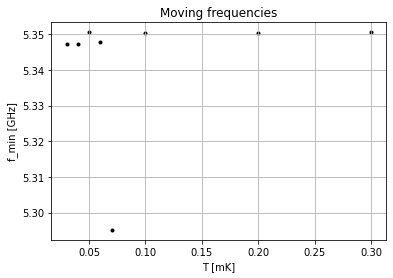

In [9]:
plt.scatter(x,y, marker='.',color='black')
plt.xlabel('T [mK]')
plt.ylabel('f_min [GHz]')
#plt.ylim([3.1774,3.1778])
plt.title('Moving frequencies')
plt.grid()

Let's create a new file with $\frac{1}{Q}$, T and $\sigma_{T}$

In [10]:
Q_invs,Q_invs_err,Qs = [], [], []
for i in range(len(temps2)):
    Qs.append(m2[i].values['Q'])
    Q_invs.append(1/(m2[i].values['Q']))
    Q_invs_err.append(1/m2[i].values['Q']**2 * m2[i].errors['Q'])
Q_invs = np.array(Q_invs)
Q_invs_err = np.array(Q_invs_err)
new_temp2 = np.array(temps2)
datas = {'T':new_temp2,'1/Q':Q_invs,'1/Q_err':Q_invs_err}
dataframe = pd.DataFrame(data=datas)
dataframe.to_csv('Fitted.csv',sep='\t',index=False)